In [1]:
from br_demography  import municipality_migration as mm
from br_demography  import municipality_births as mb
import basedosdados as bd
from dotenv import load_dotenv
import os
import pandas as pd # importação de biblioteca de manipulação de dados tabulares
import matplotlib.pyplot as plt # importação de biblioteca de plotagem de gráficos 
import numpy as np # importação de biblioteca para cálculos matemáticos
from scipy.optimize import curve_fit # importação de função a ser utilizada para ajuste de modelo preditivo 
from itertools import product # importação de função voltada para otimização de laços de iteração
import warnings



# Carrega as variáveis de ambiente do arquivo .env
load_dotenv(dotenv_path='./br_demography/.env')

# Use as variáveis de ambiente conforme necessário
project_id = os.getenv('GOOGLE_CLOUD_PROJECT_ID')

## Obtenção e Tratamento de Dados

### Dados de Nascimento

In [2]:
df_births = mb.query_births(mun_id=4104006, project_id=project_id, start_year=2000, end_year=2022)
df_births

Downloading: 100%|██████████| 16965/16965 [00:00<00:00, 30688.56rows/s]


,Ano,Idade
0,2000,<NA>
1,2000,<NA>
2,2000,<NA>
3,2000,12
4,2000,14
...,...,...
16960,2022,42
16961,2022,42
16962,2022,43
16963,2022,44


In [3]:
df_births = mb.standard_age_groups(df=df_births, age_group_csv_path='./br_demography/source/tab/faixas_etarias_maes.csv')
df_births

Nascimentos
Ano  Faixa Etária             
2000 10 a 19 anos          204
     20 a 29 anos          442
     30 a 39 anos          153
     40 a 49 anos           11
2001 10 a 19 anos          205
...                        ...
2021 40 a 49 anos           21
2022 10 a 19 anos           60
     20 a 29 anos          415
     30 a 39 anos          203
     40 a 49 anos           17

[92 rows x 1 columns]

### Dados de População de Sexo Feminino entre 2000 e 2022 

In [4]:
df_births = df_births.reset_index().pivot_table(columns=['Ano'], index=['Faixa Etária'], values=['Nascimentos'])
df_births = df_births.droplevel(level=0, axis=1)
df_births.columns.name = None
df_births

,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Faixa Etária,,,,,,,,,,,,,,,,,,,,,
10 a 19 anos,204,205,178,199,136,147,165,150,166,147,...,172,181,165,134,146,110,92,77,69,60
20 a 29 anos,442,401,410,399,323,335,358,368,403,393,...,386,429,423,429,417,411,371,381,361,415
30 a 39 anos,153,147,153,129,129,116,132,148,165,158,...,213,219,214,211,255,225,251,199,197,203
40 a 49 anos,11,16,18,10,9,9,15,12,12,20,...,17,15,15,12,24,22,25,25,21,17


In [5]:
df_pop = pd.read_csv(filepath_or_buffer='./br_demography/results/tab/pop_municipios_rmc_2000_2022_estimativa_intercensitaria.csv', sep=';')
df_pop = df_pop[df_pop['Sexo'] == 'Feminino'].iloc[:,1:]
df_pop[df_pop['Faixa Etária'].isin(values=df_births.index)]
df_pop.set_index(keys=['Faixa Etária'], inplace=True)
df_pop.columns = df_pop.columns.astype(int)
df_pop


,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
Faixa Etária,,,,,,,,,,,,,,,,,,,,,
0 a 9 anos,3720,3661,3604,3548,3492,3437,3383,3331,3278,3227,...,3223,3239,3255,3271,3287,3303,3319,3336,3352,3369
10 a 19 anos,3517,3539,3562,3586,3609,3633,3656,3680,3704,3728,...,3677,3653,3628,3604,3579,3555,3531,3508,3484,3461
20 a 29 anos,3248,3278,3309,3340,3371,3402,3434,3466,3499,3531,...,3621,3641,3660,3679,3699,3718,3738,3758,3778,3798
30 a 39 anos,2793,2825,2858,2891,2925,2959,2993,3028,3063,3098,...,3323,3389,3456,3524,3593,3664,3736,3810,3885,3962
40 a 49 anos,1803,1872,1944,2019,2097,2178,2261,2349,2439,2533,...,2844,2919,2996,3075,3157,3240,3325,3413,3503,3596
50 a 59 anos,993,1052,1116,1183,1255,1330,1411,1496,1586,1682,...,2027,2116,2208,2305,2405,2510,2620,2735,2854,2979
60 a 69 anos,591,615,640,667,694,723,753,784,817,850,...,1085,1161,1243,1330,1423,1523,1630,1744,1867,1998
70 a 79 anos,268,282,298,315,332,351,371,391,413,436,...,547,579,613,649,687,727,770,815,863,914
80 anos ou mais,63,68,74,81,88,96,105,115,125,136,...,186,200,215,232,250,269,289,312,336,362


## Cálculo de Taxa de Fertilidade

In [6]:
df_birth_rate_by_mothers_age_group = (df_births / df_pop).dropna(axis=0) * 1000
df_birth_rate_by_mothers_age_group.drop(columns=[2020, 2021, 2022], inplace=True)

10 a 19 anos
20 a 29 anos
30 a 39 anos
40 a 49 anos


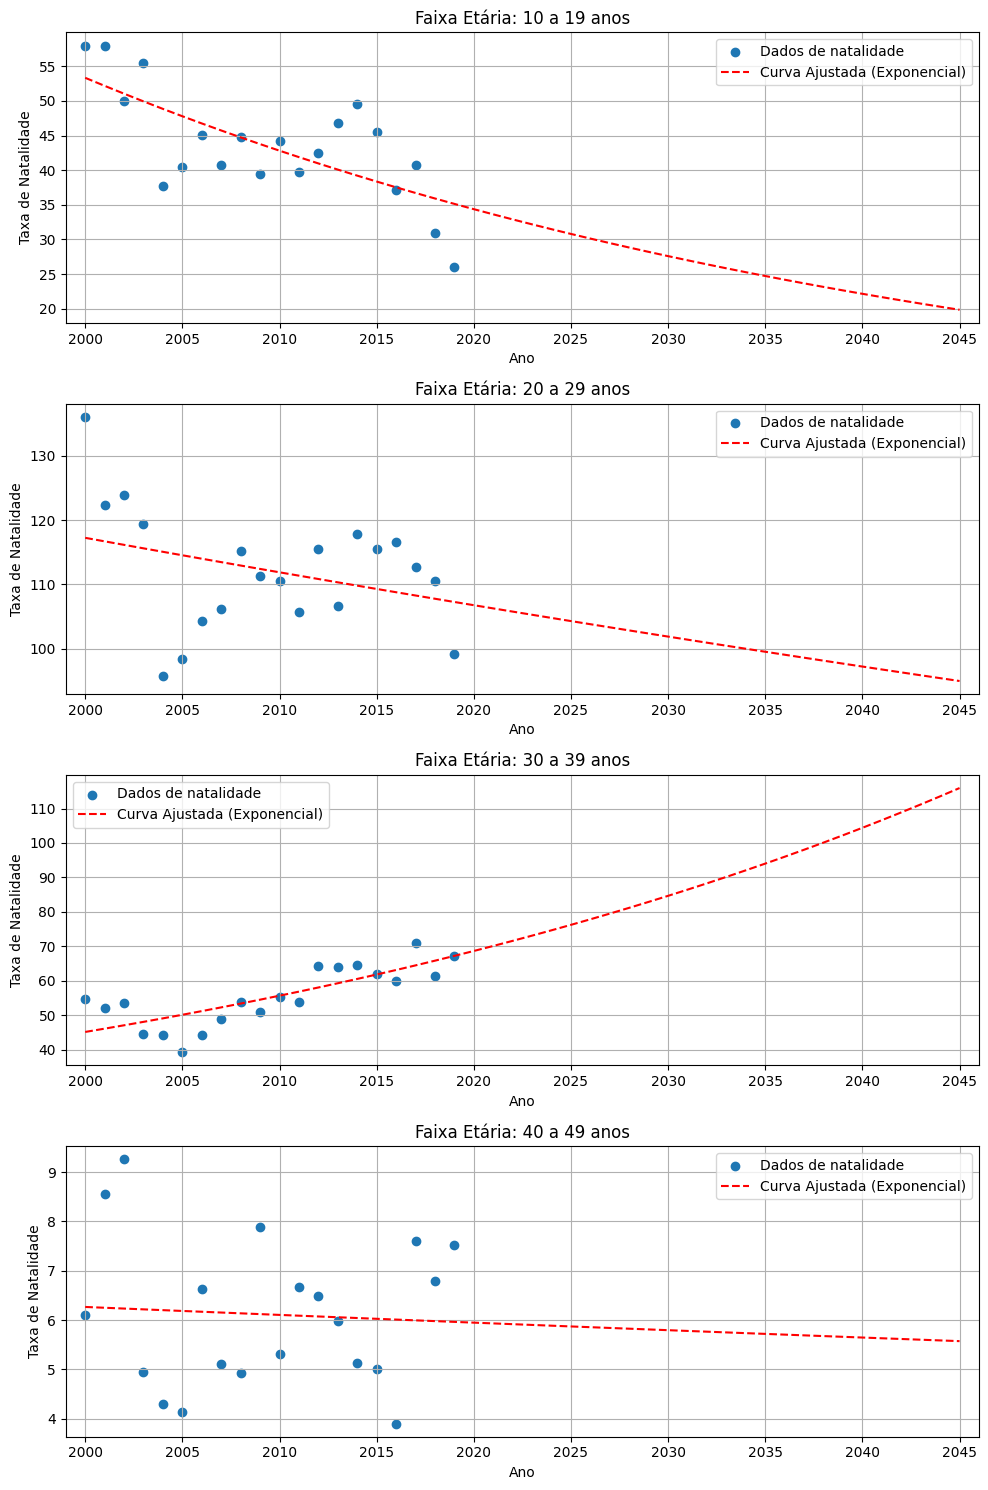

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# supressão de mensagens de alerta
np.seterr(over='ignore', invalid='ignore')
import warnings
warnings.filterwarnings('ignore')

# Função para o modelo exponencial decrescente
def modelo_exponencial_ascendente(x, constante, coeficiente):
    return constante * np.exp(coeficiente * (-x - 1))

# Função para o modelo logístico
def modelo_logistico(x, constante, coeficiente, limite):
    return limite / (1 + np.exp(-coeficiente * (x - 1))) + constante

# DataFrame de resultados
resultados = pd.DataFrame(columns=['Faixa Etária', 'Constante', 'Coeficiente'])

# Preparação de dados necessários ao laço de iteração
df_birth_rate_by_mothers_age_group.reset_index(inplace=True)
faixas_etarias = df_birth_rate_by_mothers_age_group['Faixa Etária'].unique()
num_plots = len(faixas_etarias)
num_colunas = 1
num_linhas = 4

# Criação de subplots para cada faixa etária
fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(10, 15))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

# laço de iteração
for i, faixa_etaria in enumerate(faixas_etarias):
    print(faixa_etaria)
    if i >= num_plots:
        break  # Sair se todos os subplots já estiverem preenchidos
    
    # Filtragem do DataFrame para a faixa etária atual
    df_filtro = df_birth_rate_by_mothers_age_group[df_birth_rate_by_mothers_age_group['Faixa Etária'] == faixa_etaria]
    
    # Atribuição de dados de anos e natalidade a suas variáveis para o modelo
    anos = np.array(df_filtro.columns[1:], dtype=int) - 1996
    dados_natalidade = df_filtro.iloc[0, 1:].values.astype(float)
    
    # Ajuste do modelo exponencial aos dados
    try:
        params, _ = curve_fit(modelo_exponencial_ascendente, anos, dados_natalidade, maxfev=10000)
        constante, coeficiente = params
        # Se o coeficiente for negativo, ajustar o modelo logístico
        if coeficiente < 0:
            params, _ = curve_fit(modelo_logistico, anos, dados_natalidade, maxfev=10000)
            constante, coeficiente, limite = params
            previsao = modelo_logistico(anos, constante, coeficiente, limite)
        else:
            previsao = modelo_exponencial_ascendente(anos, constante, coeficiente)
    except RuntimeError:
        constante, coeficiente = np.nan, np.nan
        previsao = np.nan * anos
    
    # Criação de um DataFrame temporário com os resultados atuais
    df_temp = pd.DataFrame({'Faixa Etária': [faixa_etaria],
                            'Constante': [constante], 'Coeficiente': [coeficiente]})
    
    # Concatenação do DataFrame temporário ao DataFrame de resultados
    resultados = pd.concat([resultados, df_temp], ignore_index=True)

    # Plotagem dos dados originais e a curva ajustada
    axs[i].scatter(anos + 1996, dados_natalidade, label='Dados de natalidade', marker='o')
    axs[i].plot(anos + 1996, previsao, label='Curva Ajustada', linestyle='--', color='red')
    axs[i].set_xlabel('Ano')
    axs[i].set_ylabel('Taxa de Natalidade')
    axs[i].set_title(f'Faixa Etária: {faixa_etaria}')
    axs[i].legend()
    axs[i].grid(True)
    axs[i].set_xlim(1995, 2040)  # Definir limite do eixo x de 1996 a 2040
    axs[i].set_xticks(np.arange(1995, 2040, 5))  # Definir marcações no eixo x a cada 5 anos

# Exibir os subplots
plt.tight_layout()
plt.show()
